Beijing Air Quality Forecasting Notebook

STEP 0 — Imports, constants, and Drive paths

In [ ]:
# STEP 0 - Imports & paths
import os, time, math, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

sns.set(style='whitegrid')
pd.set_option('display.max_columns', 300)

# Change this to your Drive folder or local path
DRIVE_BASE = '/content/'
TRAIN_PATH = os.path.join(DRIVE_BASE, 'train (1).csv')
TEST_PATH  = os.path.join(DRIVE_BASE, 'test (1).csv')
SAMPLE_SUB_PATH = os.path.join(DRIVE_BASE, '/content/sample_submission .csv')

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


STEP 1 — Load data & basic datetime handling

In [ ]:
# STEP 1 - Load data and set datetime index
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

# Ensure a 'datetime' column exists
if 'datetime' not in train.columns:
    raise ValueError("train.csv must contain a 'datetime' column")

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime']  = pd.to_datetime(test['datetime'])

# sort and set index
train = train.sort_values('datetime').set_index('datetime')
test  = test.sort_values('datetime').set_index('datetime')

print("Train shape:", train.shape)
print("Test shape :", test.shape)
display(train.head())


Train shape: (30676, 11)
Test shape : (13148, 10)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


STEP 2 — EDA (missingness and pm2.5 overview)

Missing values summary:


,missing_count,missing_pct
pm2.5,1921,6.262225
DEWP,0,0.000000
No,0,0.000000
TEMP,0,0.000000
PRES,0,0.000000
Is,0,0.000000
Iws,0,0.000000
Ir,0,0.000000
cbwd_NW,0,0.000000
cbwd_SE,0,0.000000


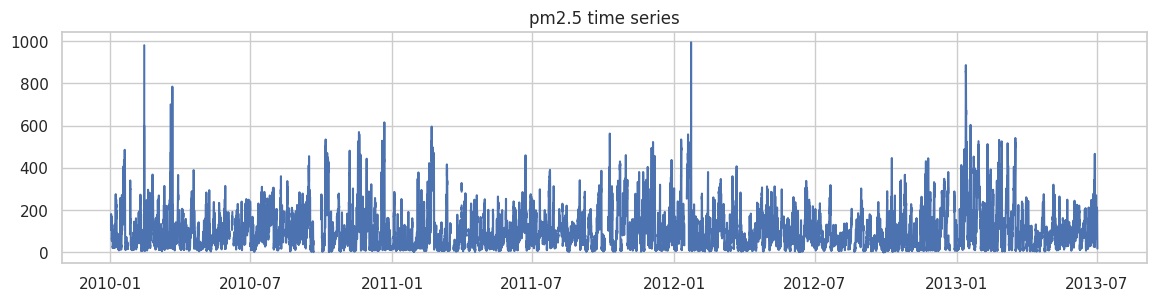

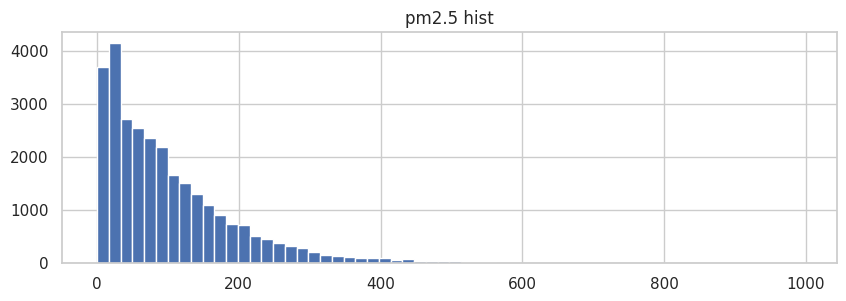

In [ ]:
# STEP 2 - Quick EDA: missingness & pm2.5 plots
print("Missing values summary:")
missing = train.isna().sum().to_frame('missing_count')
missing['missing_pct'] = 100 * missing['missing_count'] / len(train)
display(missing.sort_values('missing_pct', ascending=False))

# pm2.5 series overview if present
if 'pm2.5' in train.columns:
    plt.figure(figsize=(14,3)); plt.plot(train['pm2.5']); plt.title('pm2.5 time series'); plt.show()
    plt.figure(figsize=(10,3)); plt.hist(train['pm2.5'].dropna(), bins=60); plt.title('pm2.5 hist'); plt.show()
else:
    print("pm2.5 not found in train.")


STEP 3 — Imputation: compare and apply (time interpolation recommended)

In [ ]:
# STEP 3 - Imputation comparison (mask 5% of pm2.5 to evaluate)
mask_frac = 0.05
pm_idx = train[~train['pm2.5'].isna()].index
rng = np.random.default_rng(SEED)
mask_n = int(len(pm_idx) * mask_frac)
mask_positions = rng.choice(pm_idx, size=mask_n, replace=False)

train_masked = train.copy()
train_masked.loc[mask_positions, 'pm2.5'] = np.nan

impute_results = {}

# A - mean
tmp = train_masked.copy()
tmp['pm2.5'] = tmp['pm2.5'].fillna(train['pm2.5'].mean())
impute_results['mean'] = mean_squared_error(train.loc[mask_positions, 'pm2.5'], tmp.loc[mask_positions, 'pm2.5'])

# B - ffill/bfill
tmp = train_masked.copy()
tmp['pm2.5'] = tmp['pm2.5'].ffill().bfill()
impute_results['ffill_bfill'] = mean_squared_error(train.loc[mask_positions, 'pm2.5'], tmp.loc[mask_positions, 'pm2.5'])

# C - time interpolation
tmp = train_masked.copy()
tmp['pm2.5'] = tmp['pm2.5'].interpolate(method='time').ffill().bfill()
impute_results['time_interp'] = mean_squared_error(train.loc[mask_positions, 'pm2.5'], tmp.loc[mask_positions, 'pm2.5'])

# D - KNN
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
knn = KNNImputer(n_neighbors=5)
tmp_num = pd.DataFrame(knn.fit_transform(train_masked[num_cols]), columns=num_cols, index=train_masked.index)
impute_results['knn'] = mean_squared_error(train.loc[mask_positions, 'pm2.5'], tmp_num.loc[mask_positions, 'pm2.5'])

# print RMSEs
print("Imputation RMSEs:")
for k,v in impute_results.items():
    print(f"{k:12s} -> RMSE: {np.sqrt(v):.4f}")

# Apply chosen imputation (time interpolation chosen based on your earlier checks)
train_imputed = train.copy().interpolate(method='time').ffill().bfill()
test_imputed  = test.copy().interpolate(method='time').ffill().bfill()

print("Any NaNs left in train_imputed?", train_imputed.isna().sum().sum())
print("Any NaNs left in test_imputed?", test_imputed.isna().sum().sum())


Imputation RMSEs:
mean         -> RMSE: 88.8216
ffill_bfill  -> RMSE: 22.5204
time_interp  -> RMSE: 15.3496
knn          -> RMSE: 22.5088
Any NaNs left in train_imputed? 0
Any NaNs left in test_imputed? 0


STEP 4 — Feature engineering (time features) and scaling

In [ ]:
# STEP 4 - Add time features and scale

# Add hour/day/month
def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    # cyclical encoding for hour and day to capture periodicity
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

train_en = add_time_features(train_imputed)
test_en  = add_time_features(test_imputed)

# Select features (original numeric + newly added time features)
drop_cols = ['No'] if 'No' in train_en.columns else []
base_features = [c for c in train_imputed.columns if c not in drop_cols + ['pm2.5']]
time_feats = ['hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
features = base_features + time_feats

# Fit scaler on train features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_en[features])
X_test_scaled  = scaler.transform(test_en[features])

# Keep DataFrame wrappers for convenience
X_train_df = pd.DataFrame(X_train_scaled, index=train_en.index, columns=features)
X_test_df  = pd.DataFrame(X_test_scaled,  index=test_en.index,  columns=features)

# Target series
y_series = train_imputed['pm2.5'].values

print("Feature count:", len(features))
print("Example features:", features[:10])


Feature count: 16
Example features: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour']


STEP 5 — Sequence creation helper & train/val split helper

In [ ]:
# STEP 5 - Sequence creation and train/val split helper

def create_sequences_from_array(X_arr, y_arr=None, seq_len=24, horizon=1):
    """
    X_arr: (T, F) numpy array
    y_arr: (T,) numpy array or None
    Returns:
      if y_arr provided: (Xs, ys)
      else: Xs only
    """
    n = len(X_arr) - seq_len - (horizon-1)
    Xs, ys = [], []
    for i in range(n):
        Xs.append(X_arr[i:i+seq_len])
        if y_arr is not None:
            ys.append(y_arr[i+seq_len : i+seq_len+horizon])
    Xs = np.array(Xs)
    if y_arr is not None:
        ys = np.array(ys)
        if horizon == 1:
            ys = ys.ravel()
        return Xs, ys
    return Xs

def train_val_split_windows(X_df, y_arr, seq_len, split_frac=0.8):
    """
    Constructs sequences from X_df.values and y_arr, then perform time-based split.
    Returns ((Xtr,ytr),(Xva,yva))
    """
    Xs, ys = create_sequences_from_array(X_df.values, y_arr, seq_len=seq_len, horizon=1)
    n = len(Xs)
    split = int(n * split_frac)
    Xtr, Xva = Xs[:split], Xs[split:]
    ytr, yva = ys[:split], ys[split:]
    return (Xtr, ytr), (Xva, yva)


STEP 6 — Model builders

In [ ]:
# STEP 6 - my builder functions
def build_lstm(input_shape, units=96, dropout=0.15, dense1=64, dense2=32, bidir=False):
    m = Sequential()
    if bidir:
        m.add(Bidirectional(LSTM(units, return_sequences=False), input_shape=input_shape))
    else:
        m.add(LSTM(units, return_sequences=False, input_shape=input_shape))
    m.add(Dropout(dropout))
    m.add(Dense(dense1, activation='relu')); m.add(BatchNormalization()); m.add(Dropout(dropout*0.7))
    m.add(Dense(dense2, activation='relu')); m.add(Dropout(dropout*0.5))
    m.add(Dense(1))
    return m

def build_gru(input_shape, units=96, dropout=0.15, dense1=64, dense2=32):
    m = Sequential()
    m.add(GRU(units, return_sequences=False, input_shape=input_shape))
    m.add(Dropout(dropout))
    m.add(Dense(dense1, activation='relu')); m.add(BatchNormalization()); m.add(Dropout(dropout*0.7))
    m.add(Dense(dense2, activation='relu')); m.add(Dropout(dropout*0.5))
    m.add(Dense(1))
    return m

def build_cnn_lstm(input_shape, filters=64, k=3, lstm_units=64, dropout=0.15, dense=64):
    m = Sequential()
    m.add(Conv1D(filters, k, activation='relu', padding='same', input_shape=input_shape))
    m.add(MaxPooling1D(2))
    m.add(Conv1D(filters, k, activation='relu', padding='same'))
    m.add(GlobalAveragePooling1D())
    m.add(Dense(dense, activation='relu'))
    m.add(Dropout(dropout))
    m.add(Dense(1))
    return m

def build_deep_lstm(input_shape, units=64, dropout=0.15):
    """Two-layer LSTM for comparison"""
    m = Sequential()
    m.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    m.add(Dropout(dropout))
    m.add(LSTM(units//2, return_sequences=False))
    m.add(Dropout(dropout))
    m.add(Dense(32, activation='relu'))
    m.add(Dropout(dropout*0.5))
    m.add(Dense(1))
    return m


STEP 7 — Training helper (EarlyStopping, ReduceLR)

In [ ]:
# STEP 7 - train helper
def train_with_callbacks(model, Xtr, ytr, Xva, yva, epochs=70, batch_size=128, patience=12, lr_monitor='val_loss', exp_name='exp'):
    es = EarlyStopping(monitor=lr_monitor, patience=patience, restore_best_weights=True, verbose=0)
    rl = ReduceLROnPlateau(monitor=lr_monitor, factor=0.5, patience=6, min_lr=5e-6, verbose=0)
    hist = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=epochs, batch_size=batch_size, callbacks=[es, rl], verbose=0)
    return hist


STEP 8 — Prepare trX and y_series for experiments

In [ ]:
# STEP 8 - Prepare variables referenced by experiment block
trX = X_train_df.copy()   # scaled train features DataFrame
y_series = train_imputed['pm2.5'].values  # target aligned to train index


STEP 9 — The 16 Experiments

In [ ]:
# STEP 9 - Systematic hyperparameter search (exactly 16 experiments)
seq_lens = [24, 48, 72]  # 3 sequence lengths
# We'll pick LRs later per architecture; primary grid uses architecture-dependent defaults
architectures = [
    ('LSTM', lambda shp: build_lstm(shp, units=96, dropout=0.15)),
    ('GRU', lambda shp: build_gru(shp, units=96, dropout=0.15)),
    ('BiLSTM', lambda shp: build_lstm(shp, units=64, dropout=0.15, bidir=True)),
    ('CNN-LSTM', lambda shp: build_cnn_lstm(shp, filters=64, k=3, lstm_units=64, dropout=0.15))
]

results = []
best = {'rmse': np.inf}
experiment_count = 0

print("=== SYSTEMATIC HYPERPARAMETER SEARCH (16 EXPERIMENTS) ===")
print("Exp | Arch      | Seq_Len | LR     | Batch | RMSE   | MAE    | R2     | Time(s)")
print("-"*86)

# Experiments 1-12: 3 seq_lens × 4 architectures
for seq_len in seq_lens:
    # build train/val splits for this sequence length
    (Xtr, ytr), (Xva, yva) = train_val_split_windows(trX, y_series, seq_len, split_frac=0.8)
    input_shape = (Xtr.shape[1], Xtr.shape[2])

    for arch_name, builder in architectures:
        experiment_count += 1
        tf.keras.backend.clear_session()
        model = builder(input_shape)

        # Choose LR per architecture as you suggested
        if arch_name in ['BiLSTM', 'CNN-LSTM']:
            lr = 0.0015
        else:
            lr = 0.002

        # compile
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])

        t0 = time.time()
        _ = train_with_callbacks(model, Xtr, ytr, Xva, yva, epochs=70, batch_size=128, patience=12)
        dt = time.time() - t0

        # evaluate
        yv_pred = model.predict(Xva, verbose=0).flatten()
        rmse = math.sqrt(mean_squared_error(yva, yv_pred))
        mae = mean_absolute_error(yva, yv_pred)
        r2 = r2_score(yva, yv_pred)

        tag = f"{arch_name}_L{seq_len}_lr{lr}"
        results.append({
            'exp': experiment_count, 'tag': tag, 'seq_len': seq_len, 'arch': arch_name,
            'lr': lr, 'batch_size': 128, 'val_rmse': rmse, 'val_mae': mae, 'val_r2': r2, 'time_s': dt
        })

        print(f"{experiment_count:3d} | {arch_name:9s} | {seq_len:7d} | {lr:.4f} | {128:5d} | {rmse:6.2f} | {mae:6.2f} | {r2:6.3f} | {dt:6.1f}s")

        # update best
        if rmse < best['rmse']:
            best = {'rmse': rmse, 'mae': mae, 'r2': r2, 'seq_len': seq_len, 'arch': arch_name, 'lr': lr, 'model': model}


=== SYSTEMATIC HYPERPARAMETER SEARCH (16 EXPERIMENTS) ===
Exp | Arch      | Seq_Len | LR     | Batch | RMSE   | MAE    | R2     | Time(s)
--------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  1 | LSTM      |      24 | 0.0020 |   128 |  79.86 |  50.23 |  0.433 |   45.8s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  2 | GRU       |      24 | 0.0020 |   128 |  76.25 |  48.51 |  0.483 |   40.5s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  3 | BiLSTM    |      24 | 0.0015 |   128 |  79.53 |  51.04 |  0.437 |   36.3s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  4 | CNN-LSTM  |      24 | 0.0015 |   128 |  77.86 |  51.27 |  0.461 |   26.2s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  5 | LSTM      |      48 | 0.0020 |   128 |  77.75 |  49.28 |  0.462 |   31.7s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  6 | GRU       |      48 | 0.0020 |   128 |  71.08 |  46.64 |  0.550 |   40.4s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  7 | BiLSTM    |      48 | 0.0015 |   128 |  77.80 |  50.76 |  0.461 |   51.2s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  8 | CNN-LSTM  |      48 | 0.0015 |   128 |  80.86 |  52.81 |  0.418 |   62.8s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  9 | LSTM      |      72 | 0.0020 |   128 |  71.52 |  47.83 |  0.544 |   51.8s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 10 | GRU       |      72 | 0.0020 |   128 |  72.26 |  46.61 |  0.534 |   63.4s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 11 | BiLSTM    |      72 | 0.0015 |   128 |  75.13 |  47.74 |  0.496 |   68.1s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 12 | CNN-LSTM  |      72 | 0.0015 |   128 |  91.35 |  65.48 |  0.256 |   22.7s


STEP 10 — LR ablation (experiments 13–16) on best architecture + sequence

In [ ]:
# STEP 10 - Learning rate ablation on best architecture + sequence length
print(f"\n=== LR ABLATION ON BEST: {best['arch']} + seq_len={best['seq_len']} ===")
best_seq = best['seq_len']
best_arch_name = best['arch']
# find builder for best_arch_name
best_arch_builder = None
for name, builder in architectures:
    if name == best_arch_name:
        best_arch_builder = builder
        break
if best_arch_builder is None:
    raise ValueError("Best architecture builder not found in architectures list")

(Xtr_lr, ytr_lr), (Xva_lr, yva_lr) = train_val_split_windows(trX, y_series, best_seq, split_frac=0.8)
input_shape_lr = (Xtr_lr.shape[1], Xtr_lr.shape[2])

for lr in [0.003, 0.0012, 0.0008, 0.0005]:
    experiment_count += 1
    tf.keras.backend.clear_session()
    model = best_arch_builder(input_shape_lr)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])

    t0 = time.time()
    _ = train_with_callbacks(model, Xtr_lr, ytr_lr, Xva_lr, yva_lr, epochs=70, batch_size=128, patience=12)
    dt = time.time() - t0

    yv_pred = model.predict(Xva_lr, verbose=0).flatten()
    rmse = math.sqrt(mean_squared_error(yva_lr, yv_pred))
    mae = mean_absolute_error(yva_lr, yv_pred)
    r2 = r2_score(yva_lr, yv_pred)

    tag = f"{best_arch_name}_L{best_seq}_lr{lr}"
    results.append({
        'exp': experiment_count, 'tag': tag, 'seq_len': best_seq, 'arch': best_arch_name,
        'lr': lr, 'batch_size': 128, 'val_rmse': rmse, 'val_mae': mae, 'val_r2': r2, 'time_s': dt
    })
    print(f"{experiment_count:3d} | {best_arch_name:9s} | {best_seq:7d} | {lr:.4f} | {128:5d} | {rmse:6.2f} | {mae:6.2f} | {r2:6.3f} | {dt:6.1f}s")

    if rmse < best['rmse']:
        best = {'rmse': rmse, 'mae': mae, 'r2': r2, 'seq_len': best_seq, 'arch': best_arch_name, 'lr': lr, 'model': model}

print(f"\n=== TOTAL EXPERIMENTS: {experiment_count} (TARGET: 16) ===")
assert experiment_count == 16, f"Expected 16 experiments, got {experiment_count}"



=== LR ABLATION ON BEST: GRU + seq_len=48 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 13 | GRU       |      48 | 0.0030 |   128 |  74.55 |  47.51 |  0.505 |   45.7s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 14 | GRU       |      48 | 0.0012 |   128 |  72.89 |  47.10 |  0.527 |   35.5s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 15 | GRU       |      48 | 0.0008 |   128 |  70.14 |  45.94 |  0.562 |   62.8s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 16 | GRU       |      48 | 0.0005 |   128 |  79.73 |  49.64 |  0.434 |   65.8s

=== TOTAL EXPERIMENTS: 16 (TARGET: 16) ===


STEP 11 — Save experiment table & show best summary

In [ ]:
# STEP 11 - Save experiments to CSV and print best summary
res_df = pd.DataFrame(results).sort_values('val_rmse').reset_index(drop=True)
out_csv = os.path.join(DRIVE_BASE, 'experiment_grid_results.csv')
res_df.to_csv(out_csv, index=False)
print("Saved experiment results to:", out_csv)
display(res_df.head(12))

print("\nBest experiment summary:")
print(best)


Saved experiment results to: /content/experiment_grid_results.csv


,exp,tag,seq_len,arch,lr,batch_size,val_rmse,val_mae,val_r2,time_s
0,15,GRU_L48_lr0.0008,48,GRU,0.0008,128,70.136931,45.940719,0.562093,62.775022
1,6,GRU_L48_lr0.002,48,GRU,0.0020,128,71.076437,46.641562,0.550283,40.388762
2,9,LSTM_L72_lr0.002,72,LSTM,0.0020,128,71.524062,47.834712,0.543699,51.793367
3,10,GRU_L72_lr0.002,72,GRU,0.0020,128,72.256855,46.608847,0.534301,63.351544
4,14,GRU_L48_lr0.0012,48,GRU,0.0012,128,72.887655,47.095157,0.527071,35.506926
5,13,GRU_L48_lr0.003,48,GRU,0.0030,128,74.547606,47.511381,0.505285,45.716253
6,11,BiLSTM_L72_lr0.0015,72,BiLSTM,0.0015,128,75.132938,47.743522,0.496490,68.064272
7,2,GRU_L24_lr0.002,24,GRU,0.0020,128,76.247139,48.512899,0.482903,40.508276
8,5,LSTM_L48_lr0.002,48,LSTM,0.0020,128,77.754253,49.282836,0.461809,31.652916
9,7,BiLSTM_L48_lr0.0015,48,BiLSTM,0.0015,128,77.803852,50.761714,0.461122,51.235578



Best experiment summary:
{'rmse': 70.13693077463957, 'mae': 45.9407186572525, 'r2': 0.5620934366689957, 'seq_len': 48, 'arch': 'GRU', 'lr': 0.0008, 'model': <Sequential name=sequential, built=True>}


STEP 12 — Retrain best model on larger split and finalize

In [ ]:
# STEP 12 - Retrain best model architecture on larger split (95% train, 5% val)
best_seq = int(best['seq_len'])
best_arch = best['arch']
best_lr = float(best['lr'])

# prepare full sequences for best_seq
(X_full_tr, y_full_tr), (X_full_val, y_full_val) = train_val_split_windows(trX, y_series, best_seq, split_frac=0.95)
input_shape_full = (X_full_tr.shape[1], X_full_tr.shape[2])

# build a fresh model instance for the final training (do not reuse the earlier object)
if best_arch == 'LSTM':
    final_model = build_lstm(input_shape_full, units=96, dropout=0.15)
elif best_arch == 'GRU':
    final_model = build_gru(input_shape_full, units=96, dropout=0.15)
elif best_arch == 'BiLSTM':
    final_model = build_lstm(input_shape_full, units=64, dropout=0.15, bidir=True)
elif best_arch == 'CNN-LSTM':
    final_model = build_cnn_lstm(input_shape_full, filters=64, k=3, lstm_units=64, dropout=0.15)
else:
    raise ValueError("Unsupported architecture for final model")

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
print("Training final model on larger split...")
hist_final = final_model.fit(X_full_tr, y_full_tr, validation_data=(X_full_val, y_full_val), epochs=100, batch_size=128, callbacks=[EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)], verbose=2)
# Evaluate final validation
val_pred_final = final_model.predict(X_full_val).flatten()
final_val_rmse = math.sqrt(mean_squared_error(y_full_val, val_pred_final))
print("Final model val RMSE:", final_val_rmse)
# Save final model weights
final_model.save(os.path.join(DRIVE_BASE, 'final_model.h5'))
print("Saved final model.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training final model on larger split...
Epoch 1/100
228/228 - 4s - 16ms/step - loss: 12241.0000 - root_mean_squared_error: 110.6391 - val_loss: 4229.5752 - val_root_mean_squared_error: 65.0352
Epoch 2/100
228/228 - 3s - 13ms/step - loss: 4714.1143 - root_mean_squared_error: 68.6594 - val_loss: 3412.6704 - val_root_mean_squared_error: 58.4181
Epoch 3/100
228/228 - 2s - 9ms/step - loss: 3842.5264 - root_mean_squared_error: 61.9881 - val_loss: 3355.9817 - val_root_mean_squared_error: 57.9308
Epoch 4/100
228/228 - 2s - 7ms/step - loss: 3423.6719 - root_mean_squared_error: 58.5122 - val_loss: 3119.2285 - val_root_mean_squared_error: 55.8501
Epoch 5/100
228/228 - 2s - 7ms/step - loss: 3096.5496 - root_mean_squared_error: 55.6466 - val_loss: 2960.5613 - val_root_mean_squared_error: 54.4110
Epoch 6/100
228/228 - 2s - 7ms/step - loss: 2832.9773 - root_mean_squared_error: 53.2257 - val_loss: 2955.2742 - val_root_mean_squared_error: 54.3624
Epoch 7/100
228/228 - 2s - 7ms/step - loss: 2603.4751 - 

Final model val RMSE: 51.8872901160902
Saved final model.


STEP 13 — Auto-regressive forecasting for test set & prepare submission (no rounding)

In [ ]:
# STEP 13 - Forecast test set iteratively (auto-regressive) and create submission
SEQ = best_seq  # use sequence length chosen in best experiment

# Prepare scaled test feature array that matches features used in trX
X_test_arr = X_test_df.values  # (T_test, F)
n_test = len(X_test_arr)

# Initialize history buffer with LAST SEQ rows from scaled TRAIN (trX is X_train_df)
history_buffer = list(trX.values[-SEQ:].tolist())  # list of arrays

predictions = []
for t in range(n_test):
    # get input window
    window_input = np.array(history_buffer[-SEQ:]).reshape(1, SEQ, X_test_arr.shape[1])
    pred = final_model.predict(window_input, verbose=0)[0][0]
    predictions.append(pred)
    # append current test features to history buffer (we do NOT append predicted pm2.5 to features, only features)
    history_buffer.append(X_test_arr[t])

preds_array = np.array(predictions)  # floats, no rounding
print("Predictions generated:", preds_array.shape)

# Align with sample_submission length and save
n_sub = len(sample_submission)
if len(preds_array) >= n_sub:
    sub_preds = preds_array[:n_sub]
else:
    pad = np.full((n_sub - len(preds_array),), preds_array[-1] if len(preds_array)>0 else np.mean(y_series))
    sub_preds = np.concatenate([preds_array, pad])

submission = sample_submission.copy()
target_col = 'pm2.5' if 'pm2.5' in submission.columns else submission.columns[-1]
submission[target_col] = sub_preds   # keep float values

out_path = os.path.join(DRIVE_BASE, 'submission_final_float.csv')
submission.to_csv(out_path, index=False)
print("Saved submission to:", out_path)
display(submission.head())


Predictions generated: (13148,)
Saved submission to: /content/submission_final_float.csv


,row ID,pm2.5
0,2013-07-02 4:00:00,31.577709
1,2013-07-02 5:00:00,27.877451
2,2013-07-02 6:00:00,23.087278
3,2013-07-02 7:00:00,20.451313
4,2013-07-02 8:00:00,18.174622


STEP 14 - Quick wrap-up

In [ ]:
# STEP 14 - Quick wrap-up
print("Top 5 experiments (by val_rmse):")
display(res_df.sort_values('val_rmse').head())

print("Best overall RMSE (on validation during experiments):", best['rmse'])
print("Final model RMSE on hold-out 5% validation:", final_val_rmse)

# Save summary
summary = {
    'best': {'arch': best['arch'], 'seq_len': best['seq_len'], 'lr': best['lr'], 'rmse': float(best['rmse'])},
    'final_val_rmse': float(final_val_rmse),
    'experiment_csv': out_csv,
    'submission': out_path
}
import json
with open(os.path.join(DRIVE_BASE,'run_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)
print("Saved run_summary.json")


Top 5 experiments (by val_rmse):


,exp,tag,seq_len,arch,lr,batch_size,val_rmse,val_mae,val_r2,time_s
0,15,GRU_L48_lr0.0008,48,GRU,0.0008,128,70.136931,45.940719,0.562093,62.775022
1,6,GRU_L48_lr0.002,48,GRU,0.0020,128,71.076437,46.641562,0.550283,40.388762
2,9,LSTM_L72_lr0.002,72,LSTM,0.0020,128,71.524062,47.834712,0.543699,51.793367
3,10,GRU_L72_lr0.002,72,GRU,0.0020,128,72.256855,46.608847,0.534301,63.351544
4,14,GRU_L48_lr0.0012,48,GRU,0.0012,128,72.887655,47.095157,0.527071,35.506926


Best overall RMSE (on validation during experiments): 70.13693077463957
Final model RMSE on hold-out 5% validation: 51.8872901160902
Saved run_summary.json
